<a href="https://colab.research.google.com/github/YunHo0325/ai_lecture/blob/main/src/mnist_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

     |████████████████████████████████| 275 kB 21.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f41420f45147d8c7c87fd6e0cba588ce6c758b2252a77217570c6b4ddc27a5c5
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.util import montage as montage2d
from skimage.segmentation import mark_boundaries
%matplotlib inline

In [3]:
def cnnModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                    activation='relu',
                    input_shape=(28, 28, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
 x_train = np.stack([gray2rgb(iimg) for iimg in x_train], 0)
 x_test = np.stack([gray2rgb(iimg) for iimg in x_test], 0)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.3, 
                                                  random_state=2020)

In [8]:
y_train_oh = tf.keras.utils.to_categorical(y_train)
y_val_oh = tf.keras.utils.to_categorical(y_val)
y_test_oh = tf.keras.utils.to_categorical(y_test)

In [10]:
tf.keras.backend.clear_session()    # 세션 초기화
model = cnnModel()

# 모델 컴파일 : loss = 'categorical_crossentropy'
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [11]:
# 모델 훈련
history = model.fit(x_train, y_train_oh, 
                    epochs=5,
                    validation_data=(x_val, y_val_oh))

Epoch 1/5
1313/1313 [==============================] - 95s 72ms/step - loss: 0.1486 - accuracy: 0.9528 - val_loss: 0.0540 - val_accuracy: 0.9841
Epoch 2/5
1313/1313 [==============================] - 94s 71ms/step - loss: 0.0621 - accuracy: 0.9796 - val_loss: 0.0605 - val_accuracy: 0.9816
Epoch 3/5
1313/1313 [==============================] - 93s 71ms/step - loss: 0.0487 - accuracy: 0.9851 - val_loss: 0.0494 - val_accuracy: 0.9861
Epoch 4/5
1313/1313 [==============================] - 96s 73ms/step - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0513 - val_accuracy: 0.9862
Epoch 5/5
1313/1313 [==============================] - 94s 72ms/step - loss: 0.0346 - accuracy: 0.9889 - val_loss: 0.0547 - val_accuracy: 0.9837


In [19]:
def predict(data):
    data = data.reshape(-1, 28, 28, 3)
    pred = model.predict(data)
    return pred

In [13]:
explainer = lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(기본), slic, felzenszwalb
segmenter = SegmentationAlgorithm('slic',
                                 n_segments=100,
                                 compactness=1,
                                 sigma=1)

In [20]:
idx= 1
exp = explainer.explain_instance(x_test[idx],
                                 classifier_fn=predict,
                                 top_labels=10,
                                 num_samples=500,
                                 segmentation_fn=segmenter
                                )

/usr/local/lib/python3.7/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/500 [00:00<?, ?it/s]

class : 2, pred : 2


Text(0.5, 1.0, 'Show mask only')

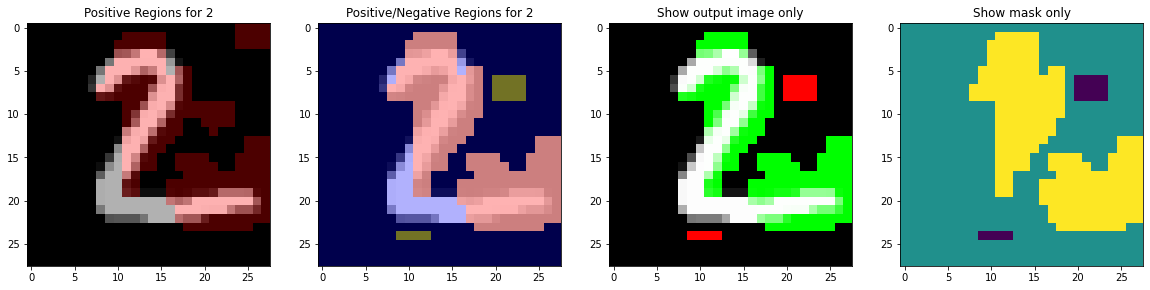

In [25]:
print(f"class : {y_test[idx]}, pred : {np.argmax(predict(x_test[idx]))}")
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 20))

# 에측에 도움이 되는 세그먼트 출력
temp, mask = exp.get_image_and_mask(y_test[idx], 
                                   positive_only=True,
                                   num_features=8,
                                   hide_rest=False)
# ax1.imshow(mark_boundaries(temp, mask))
ax1.imshow(label2rgb(mask, temp, bg_label = 0),
          interpolation = 'nearest')
ax1.set_title(f'Positive Regions for {y_test[idx]}')

# 모든 세그먼트 출력
temp, mask = exp.get_image_and_mask(y_test[idx], 
                                   positive_only=False,
                                   num_features=8,
                                   hide_rest=False)
# ax2.imshow(mark_boundaries(temp, 4-mask))
ax2.imshow(label2rgb(4-mask, temp, bg_label = 0),
          interpolation = 'nearest')
ax2.set_title(f'Positive/Negative Regions for {y_test[idx]}')

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation = 'nearest')
ax4.set_title('Show mask only')